# Kat E3.5 - E4.5 velocity

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import scvelo as scv

from matplotlib import rcParams

random_seed = 12345
np.random.seed(random_seed)
sc.settings.set_figure_params(dpi=80)

scv.settings.verbosity = 3  # show errors(0), warnings(1), info(2), hints(3)
scv.settings.presenter_view = True  # set max width size for presenter view
scv.settings.set_figure_params('scvelo')  # for beautified visualization

rcParams['figure.figsize'] = 7, 7
%matplotlib inline

## Load velocity

In [ ]:
import anndata
from scipy import sparse

def buildAnndataFromStar(path):
    """Generate an anndata object from the STAR aligner output folder"""
    path=path
    # Load Read Counts
    X = sc.read_mtx(path+'Gene/raw/matrix.mtx')
    
    # Transpose counts matrix to have Cells as rows and Genes as cols as expected by AnnData objects
    X = X.X.transpose()
    
    # This matrix is organized as a sparse matrix with Row, Cols and 3 values columns for 
    # Spliced, Unspliced and Ambigous reads
    mtx = np.loadtxt(path+'Velocyto/raw/matrix.mtx', skiprows=3, delimiter=' ')
    # Extract sparse matrix shape informations from the third row
    shape = np.loadtxt(path+'Velocyto/raw/matrix.mtx', skiprows=2, max_rows = 1 ,delimiter=' ')[0:2].astype(int)

    # Read the sparse matrix with csr_matrix((data, (row_ind, col_ind)), shape=(M, N))
    # Subract -1 to rows and cols index because csr_matrix expects a 0 based index
    # Traspose counts matrix to have Cells as rows and Genes as cols as expected by AnnData objects
    spliced = sparse.csr_matrix((mtx[:,2], (mtx[:,0]-1, mtx[:,1]-1)), shape = shape).transpose()
    unspliced = sparse.csr_matrix((mtx[:,3], (mtx[:,0]-1, mtx[:,1]-1)), shape = shape).transpose()
    ambiguous = sparse.csr_matrix((mtx[:,4], (mtx[:,0]-1, mtx[:,1]-1)), shape = shape).transpose()
    
    # Load Genes and Cells identifiers
    obs = pd.read_csv(path+'Velocyto/raw/barcodes.tsv', header = None, index_col = 0)
    # Remove index column name to make it compliant with the anndata format
    obs.index.name = None
    
    var = pd.read_csv(path+'Velocyto/raw/features.tsv', sep='\t', names = ('gene_ids', 'feature_types'), index_col = 1)
    
    # Build AnnData object to be used with ScanPy and ScVelo
    adata = anndata.AnnData(X = X, obs = obs, var = var,
                        layers = {'spliced': spliced, 'unspliced': unspliced, 'ambiguous': ambiguous})
    adata.var_names_make_unique()
    
    # Subset Cells based on STAR filtering
    selected_barcodes = pd.read_csv(path+'Gene/filtered/barcodes.tsv', header = None)
    adata = adata[selected_barcodes[0]]
    
    return adata.copy()

In [ ]:
e3_5 = buildAnndataFromStar('../data/velocity/E3_5/Solo.out/')
e3_5.var_names_make_unique()

In [ ]:
e4_5 = buildAnndataFromStar('../data/velocity/E4_5/Solo.out/')
e4_5.var_names_make_unique()

In [ ]:
adata_e3_5 = adata[adata.obs.Timepoint == "E3.5"].copy()
adata_e3_5.obs_names = [cell[2] for cell in adata_e3_5.obs_names.str.split('_', expand=True).values]

adata_e4_5 = adata[adata.obs.Timepoint == "E4.5"].copy()
adata_e4_5.obs_names = [cell[2] for cell in adata_e4_5.obs_names.str.split('_', expand=True).values]

In [ ]:
adata_velocity = scv.utils.merge(adata_e3_5, e3_5).concatenate(scv.utils.merge(adata_e4_5, e4_5))

In [ ]:
adata_velocity.write("../data/processed/03_merged_velocity.h5ad")

## Velocity

In [2]:
adata = sc.read('../data/processed/kat-replicated.h5')
adata_velocity = sc.read('../data/processed/03_merged_velocity.h5ad')

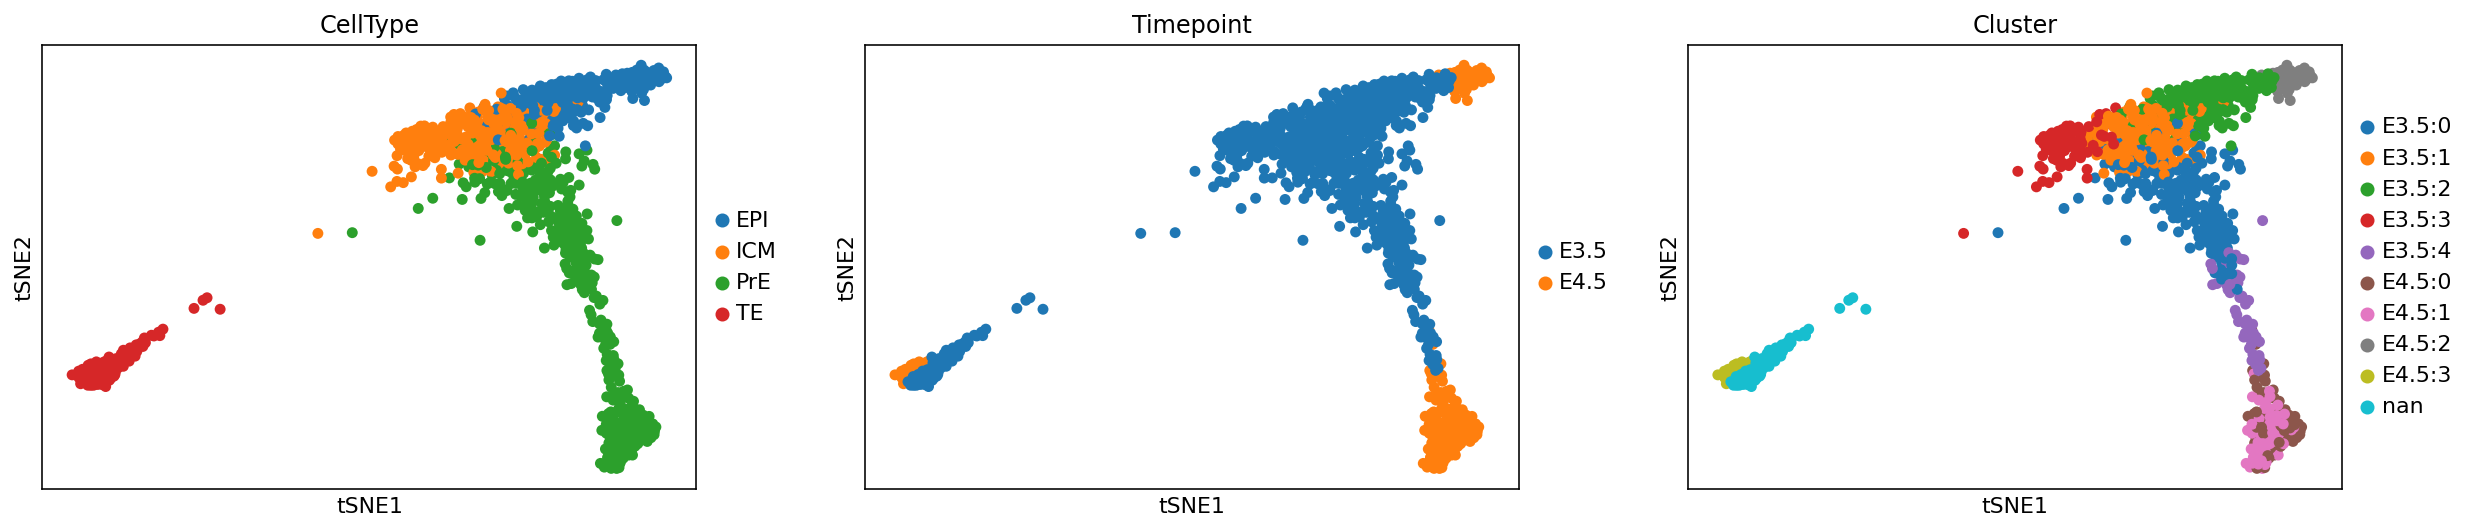

In [3]:
sc.pl.tsne(adata, color=['CellType', 'Timepoint', 'Cluster'])

In [4]:
print(f"Before {adata.shape}\nAfter {adata_velocity.shape}")

Before (1006, 20897)
After (991, 19835)


In [5]:
adata_velocity.obs['Time_CellType'] = adata_velocity.obs.CellType.astype(str) + "-" + adata_velocity.obs.Timepoint.astype(str)
adata_velocity.obs['Time_CellType'] = adata_velocity.obs['Time_CellType'].astype('category')

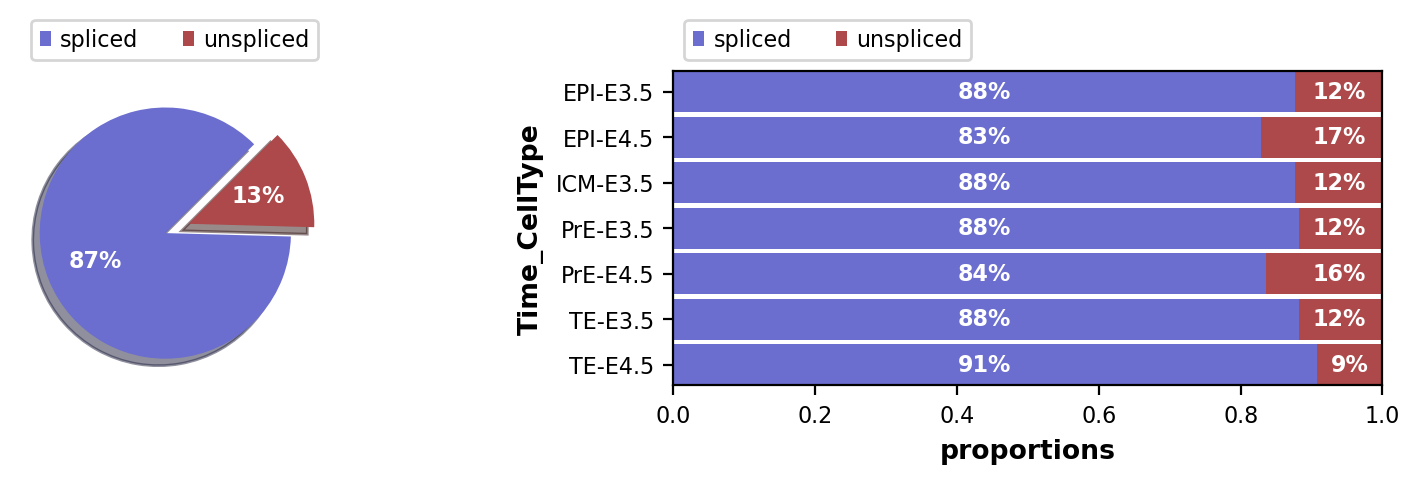

In [6]:
scv.pl.proportions(adata_velocity, groupby="Time_CellType")

In [7]:
scv.pp.filter_and_normalize(adata_velocity, min_shared_counts=20, n_top_genes=2_000)
scv.pp.moments(adata_velocity, n_pcs=30, n_neighbors=30)

Filtered out 11991 genes that are detected 20 counts (shared).
Normalized count data: spliced, unspliced.
Extracted 2000 highly variable genes.
computing neighbors
    finished (0:00:13) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [8]:
scv.tl.recover_dynamics(adata_velocity, n_jobs=6)

recovering dynamics (using 6/12 cores)


  0%|          | 0/1216 [00:00<?, ?gene/s]

    finished (0:00:47) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)


In [9]:
scv.tl.velocity(adata_velocity, mode='dynamical')
scv.tl.velocity_graph(adata_velocity)

computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


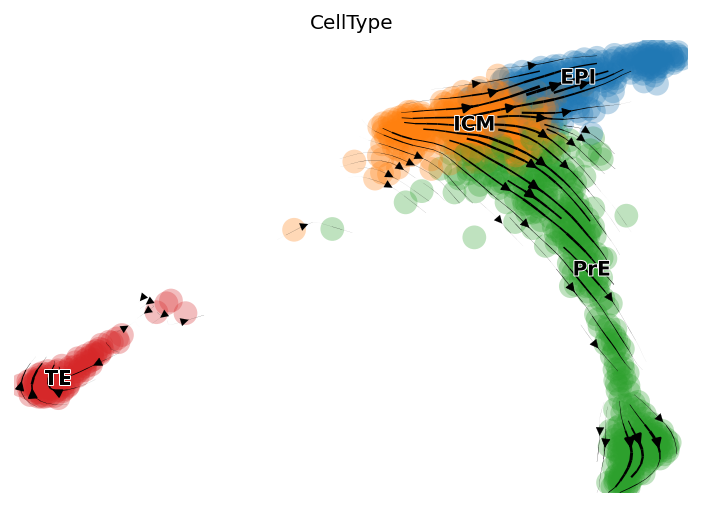

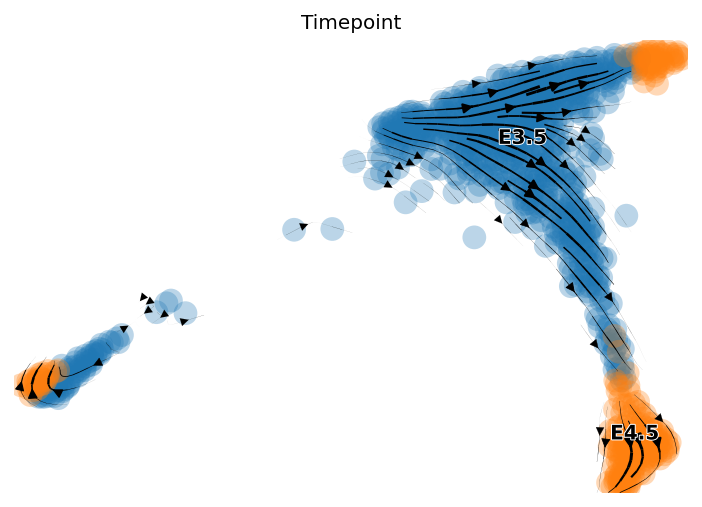

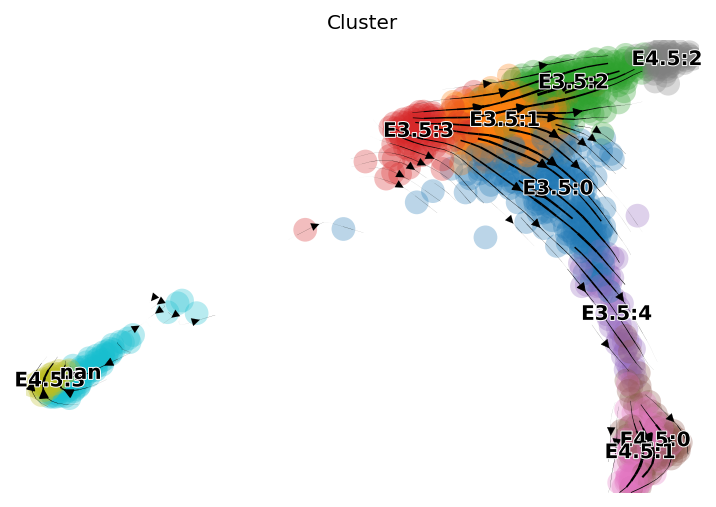

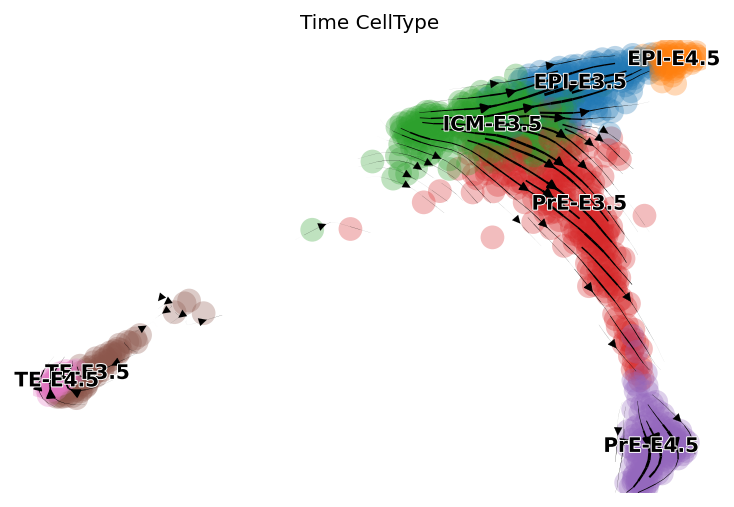

In [20]:
scv.pl.velocity_embedding_stream(adata_velocity, basis='tsne', color='CellType')
scv.pl.velocity_embedding_stream(adata_velocity, basis='tsne', color='Timepoint')
scv.pl.velocity_embedding_stream(adata_velocity, basis='tsne', color='Cluster')
scv.pl.velocity_embedding_stream(adata_velocity, basis='tsne', color='Time_CellType')

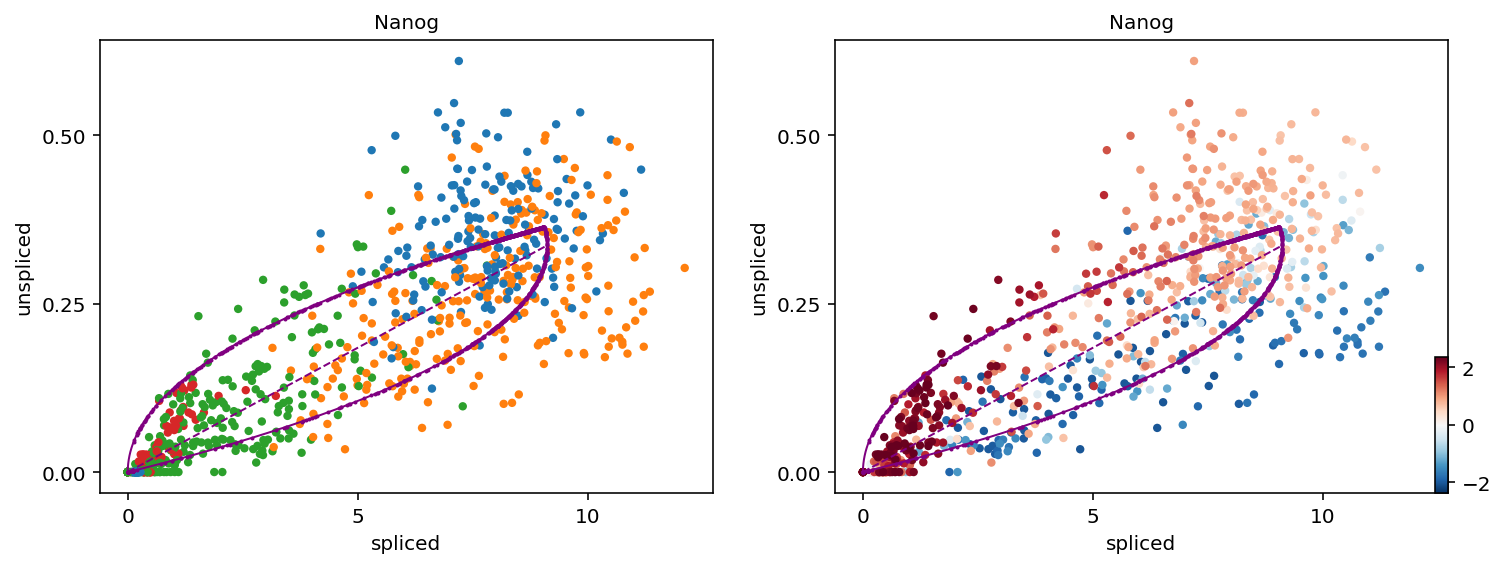

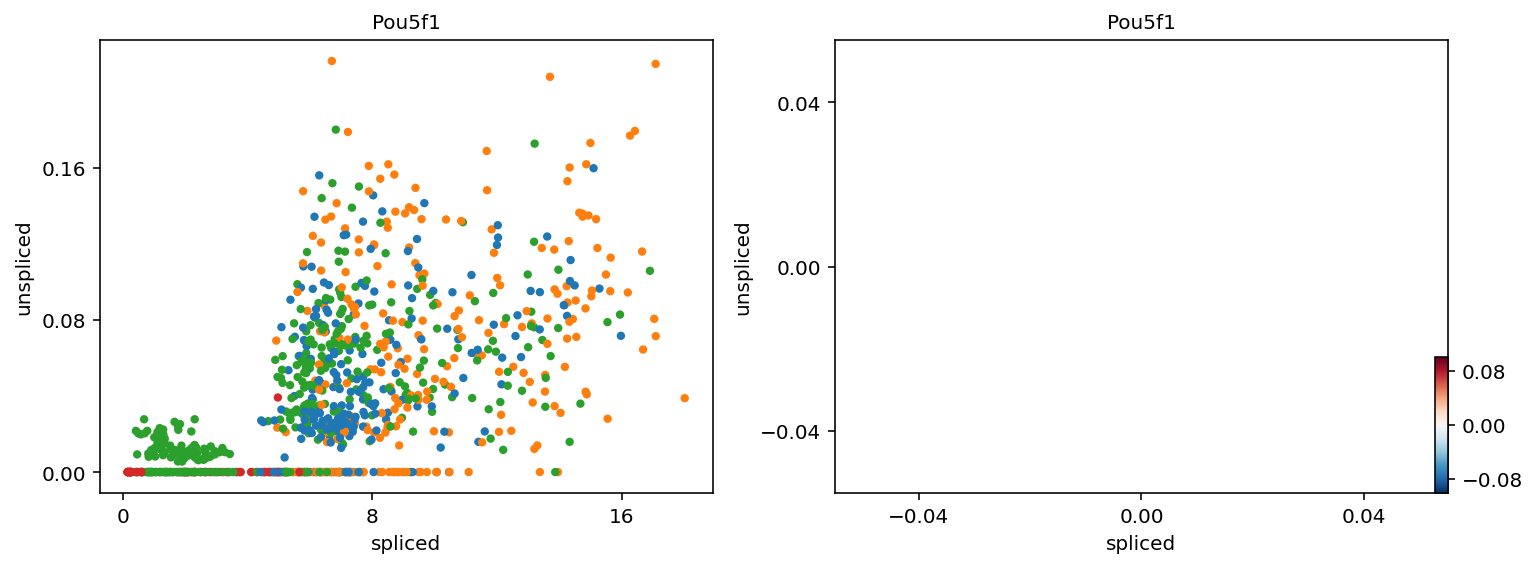

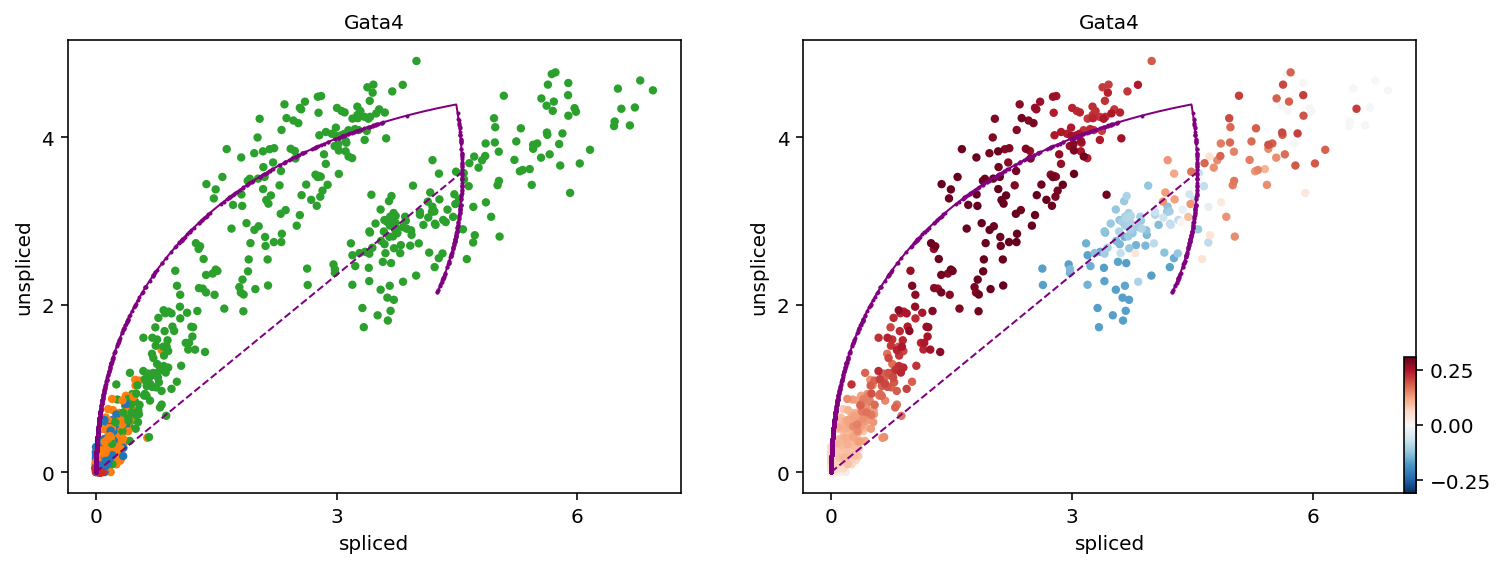

In [11]:
scv.pl.scatter(adata_velocity, 'Nanog', color=['CellType', 'velocity'])
scv.pl.scatter(adata_velocity, 'Pou5f1', color=['CellType', 'velocity'])
scv.pl.scatter(adata_velocity, 'Gata4', color=['CellType', 'velocity'])

### Drivers of `CellType`

In [12]:
scv.tl.rank_velocity_genes(adata_velocity, groupby='CellType', min_corr=.3)

df = scv.DataFrame(adata_velocity.uns['rank_velocity_genes']['names'])
df.head(20)

ranking velocity genes
    finished (0:00:00) --> added 
    'rank_velocity_genes', sorted scores by group ids (adata.uns) 
    'spearmans_score', spearmans correlation scores (adata.var)


,EPI,ICM,PrE,TE
0,2410141K09Rik,Mep1b,Egflam,Wnk2
1,Marcks,Glb1,Ncoa7,Tspan9
2,Rnf125,Adam19,Creb3l2,Wdr72
3,Atp1b1,Ppargc1b,Efr3b,Cpd
4,Arl14epl,Prom1,Dip2c,Ggta1
5,Abi2,Pml,Mvb12b,Arhgap18
6,Shkbp1,Cd109,Frmd4a,Ptk2b
7,Tbx3,Aqp9,Smim22,Ceacam10
8,Glud1,Kyat3,Amot,Wipf1
9,Zmpste24,Rnf130,P4ha1,Trpm6


### Drivers of `Time_CellType`

In [13]:
scv.tl.rank_velocity_genes(adata_velocity, groupby='Time_CellType', min_corr=.3)

df = scv.DataFrame(adata_velocity.uns['rank_velocity_genes']['names'])
df.head(20)

ranking velocity genes
    finished (0:00:00) --> added 
    'rank_velocity_genes', sorted scores by group ids (adata.uns) 
    'spearmans_score', spearmans correlation scores (adata.var)


,EPI-E3.5,EPI-E4.5,ICM-E3.5,PrE-E3.5,PrE-E4.5,TE-E3.5,TE-E4.5
0,Arl14epl,Cmtm7,Mep1b,Gata4,Nox4,Anxa2,Tfap2a
1,Mtss1,Fstl1,Glb1,Col4a2,Msi2,Wdr72,Wipf1
2,2410141K09Rik,Epcam,Adam19,Col4a1,Gpc3,Slc28a3,Ei24
3,Acsl6,Vgll4,Ppargc1b,Gdpd5,Sycp3,Entpd1,Cyct
4,Phc1,Msn,Prom1,Eps8,P3h2,Csrp1,Tjp3
5,Pygb,Lef1,Pml,Atf6,Tgfbr3,Tspan9,Ptk2b
6,Nav2,Emb,Cd109,Lamc1,Smim22,Wnk2,Pdgfa
7,Platr10,Efnb2,Aqp9,Lama1,Prdm6,Rbms1,Lurap1l
8,Mras,Psap,Kyat3,Soat1,Kcng1,Efhd2,Arhgap22
9,Anxa6,Atp1b1,Rnf130,Plod2,Epb41l3,Synj1,Chd9


### Cell Cycle

calculating cell cycle phase
-->     'S_score' and 'G2M_score', scores of cell cycle phases (adata.obs)


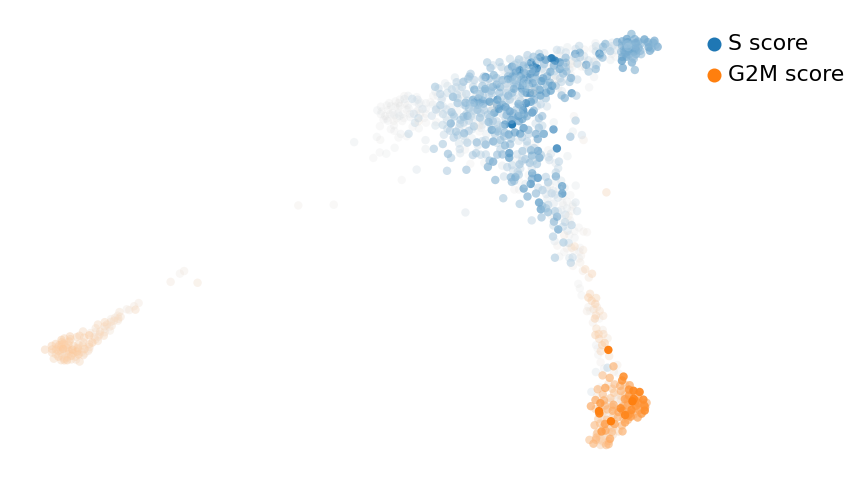

In [14]:
scv.tl.score_genes_cell_cycle(adata_velocity)
scv.pl.scatter(adata_velocity, color_gradients=['S_score', 'G2M_score'], smooth=True, perc=[5, 95])

## Debug

--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence' (adata.obs)
--> added 'velocity_confidence_transition' (adata.obs)


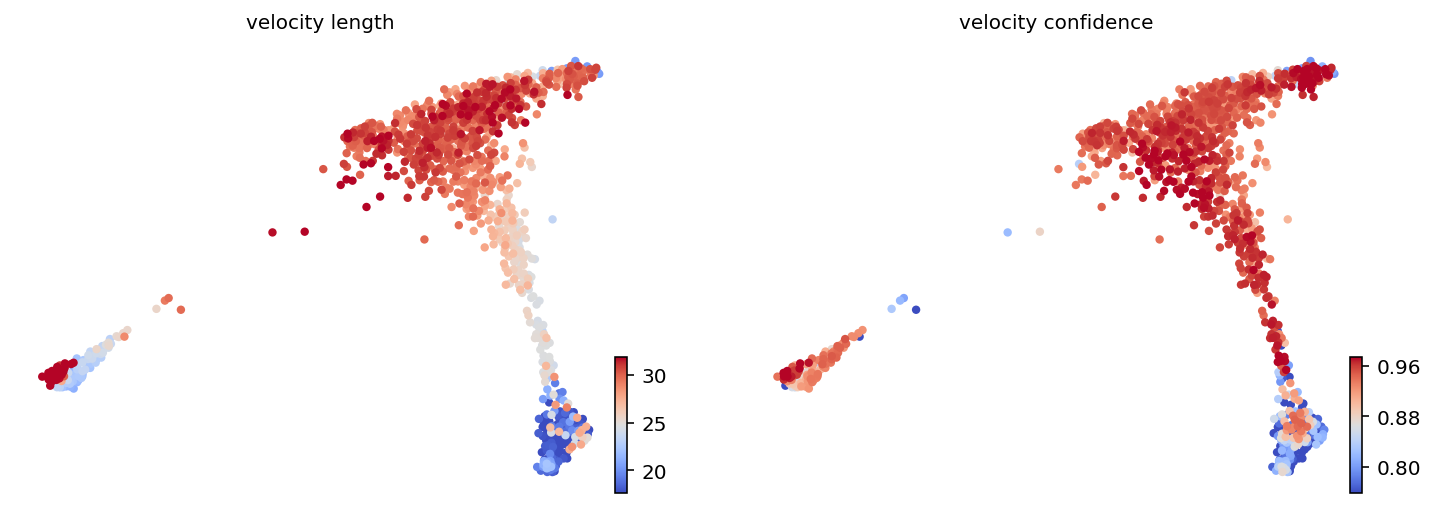

In [15]:
scv.tl.velocity_confidence(adata_velocity)
scv.pl.scatter(adata_velocity, c=['velocity_length', 'velocity_confidence'], cmap='coolwarm', perc=[5, 95])

## Latent time

computing terminal states
    identified 1 region of root cells and 2 regions of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time using root_cells as prior
    finished (0:00:00) --> added 
    'latent_time', shared time (adata.obs)


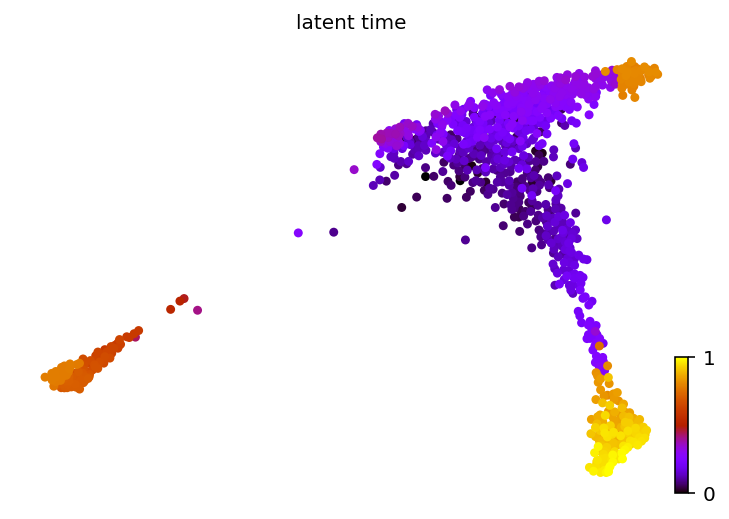

In [16]:
scv.tl.latent_time(adata_velocity)
scv.pl.scatter(adata_velocity, color='latent_time', color_map='gnuplot', size=80)

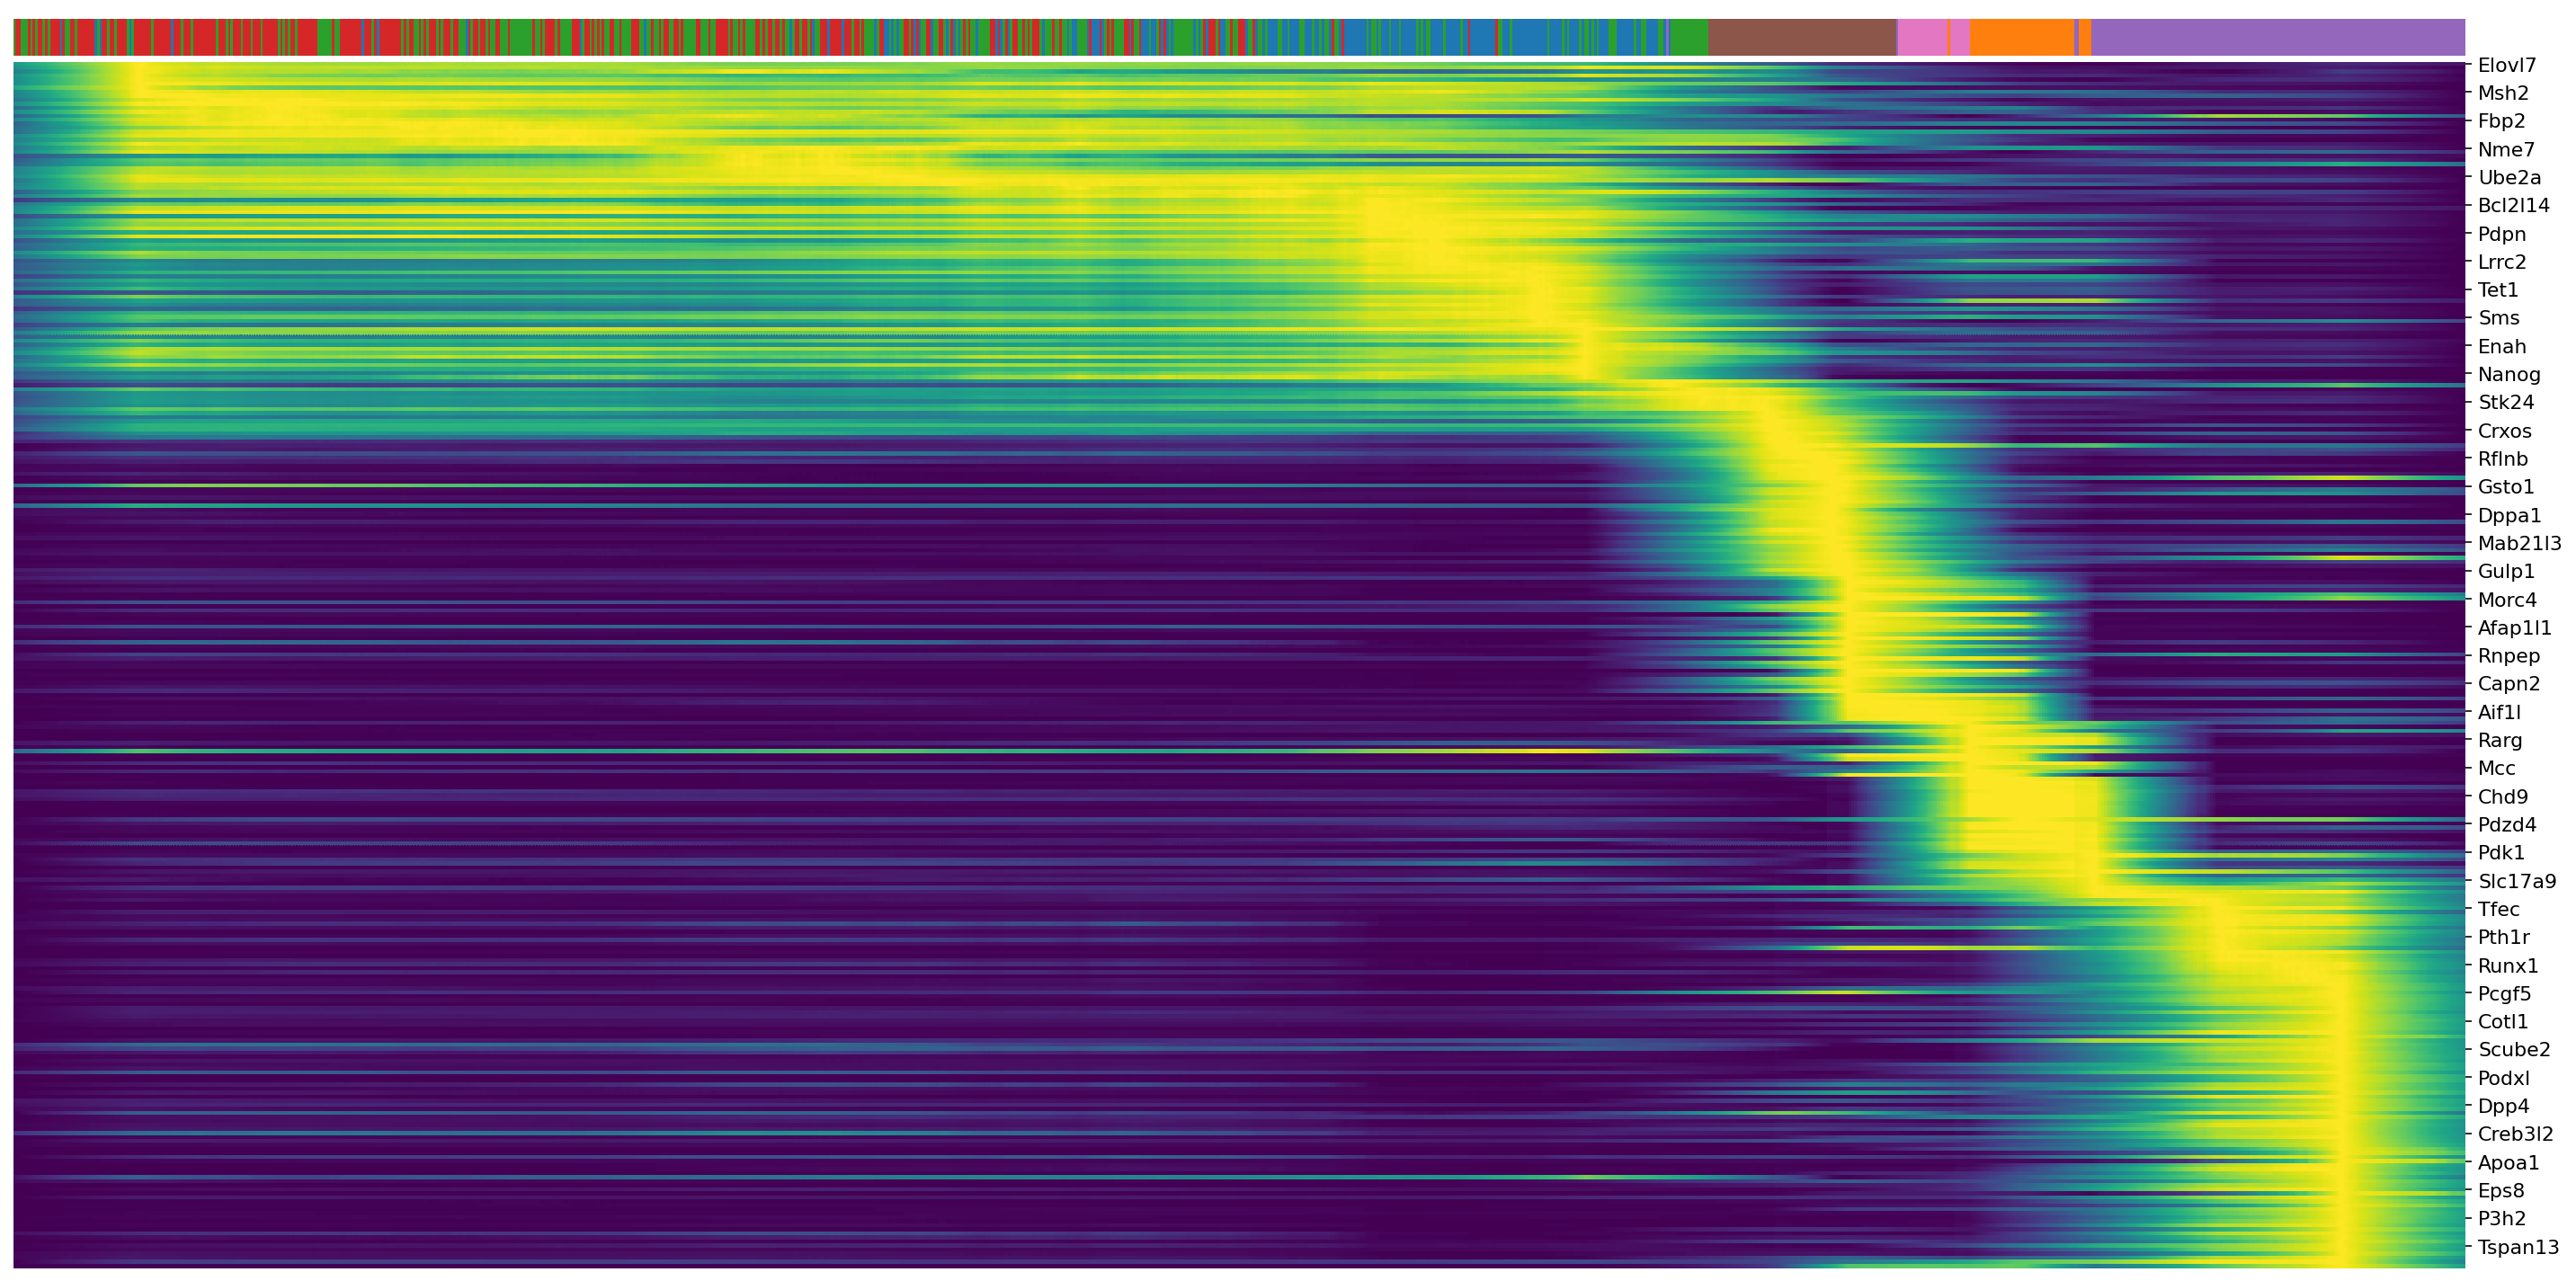

In [19]:
top_genes = adata_velocity.var['fit_likelihood'].sort_values(ascending=False).index[:300]
scv.pl.heatmap(adata_velocity, var_names=top_genes, sortby='latent_time', col_color='Time_CellType', n_convolve=100, figsize=[20, 10])

### Cluster-specific top-likelihood genes

In [22]:
scv.tl.rank_dynamical_genes(adata_velocity, groupby='Time_CellType')
df = scv.get_df(adata_velocity, 'rank_dynamical_genes/names')
df.head(20)

ranking genes by cluster-specific likelihoods
    finished (0:00:00) --> added 
    'rank_dynamical_genes', sorted scores by group ids (adata.uns)


,EPI-E3.5,EPI-E4.5,ICM-E3.5,PrE-E3.5,PrE-E4.5,TE-E3.5,TE-E4.5
0,Fbp2,Aire,Rnf130,Rnf130,Oat,Bcat1,Egfr
1,Rnf130,Igfbp2,Bcat1,Bcat1,Trpm6,Gata3,Elf5
2,Gabarapl2,Lef1,Fbp2,Ndfip1,Dab2,Tmprss2,Ptger3
3,AU020206,Bst2,Ndfip1,Gabarapl2,Prss12,Reep1,Wipf3
4,Ndfip1,Col18a1,Csf3r,Jarid2,Kdelr3,Entpd1,Slc7a8
5,Enah,Emb,AU020206,Fgfr2,Iqgap2,Tinagl1,Cbfa2t3
6,Arid5b,Exoc3l,Esrrb,Gata4,Rnpep,Nr5a2,Hpgd
7,Nr5a2,Soga3,Enah,Sms,Tfec,Ankrd33b,Efs
8,Upp1,Cyb5b,Lpcat3,Zmat5,Cmtm8,Gabarapl2,Krt19
9,Mep1b,Epcam,Smagp,Fbp2,Bag2,Jarid2,Cald1


In [23]:
!jupyter nbconvert --to html 03_velocity.ipynb --output-dir="../reports"

[NbConvertApp] Converting notebook 03_velocity.ipynb to html
[NbConvertApp] Writing 2913054 bytes to ../reports/03_velocity.html
